# Training a NN to Improve Raw ORB/RANSAC Outputs

In [21]:
# Read in data from nn_X.csv and nn_Y.csv. Train a neural network on the data.

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Read in data. Ignore the chain_id column and the i column.
X = pd.read_csv('nn_X.csv').drop(columns=['chain_id', 'i']).to_numpy()
Y = pd.read_csv('nn_Y.csv').drop(columns=['chain_id', 'i']).to_numpy()


# DATA NORMALISATION
# Normalise the range column from [20, 600] to [0, 1].
X[:, 0] = (X[:, 0] - 20) / (600 - 20)

# Normalise the x, y, z columns from [-1000, 1000] to [-1, 1].
X[:, 1:4] = (X[:, 1:4] / 1000)
Y[:, 0:3] = (Y[:, 0:3] / 1000)

# FEATURE ENGINEERING
# For each of the columns x, y, z, qw, qx, qy, qz, add a column x^2, y^2, z^2, etc.
# This is to help it learn formulae that depend on the square of these values.
X = np.hstack([X, X[:, 1:]**2])

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Convert data to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.float32)

# Create neural network
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='sigmoid', input_shape=(X.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(Y.shape[1])
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train neural network
history = model.fit(X_train, Y_train, epochs=150, batch_size=25, validation_data=(X_test, Y_test), verbose=2)

# Evaluate neural network
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
print(f'Mean squared error: {mse}')


Epoch 1/150


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 - 1s - 42ms/step - loss: 0.2312 - val_loss: 0.0196
Epoch 2/150
32/32 - 0s - 3ms/step - loss: 0.0650 - val_loss: 0.0167
Epoch 3/150
32/32 - 0s - 3ms/step - loss: 0.0533 - val_loss: 0.0161
Epoch 4/150
32/32 - 0s - 3ms/step - loss: 0.0486 - val_loss: 0.0166
Epoch 5/150
32/32 - 0s - 2ms/step - loss: 0.0432 - val_loss: 0.0163
Epoch 6/150
32/32 - 0s - 3ms/step - loss: 0.0406 - val_loss: 0.0161
Epoch 7/150
32/32 - 0s - 3ms/step - loss: 0.0367 - val_loss: 0.0168
Epoch 8/150
32/32 - 0s - 3ms/step - loss: 0.0356 - val_loss: 0.0167
Epoch 9/150
32/32 - 0s - 3ms/step - loss: 0.0351 - val_loss: 0.0169
Epoch 10/150
32/32 - 0s - 4ms/step - loss: 0.0319 - val_loss: 0.0163
Epoch 11/150
32/32 - 0s - 3ms/step - loss: 0.0303 - val_loss: 0.0168
Epoch 12/150
32/32 - 0s - 3ms/step - loss: 0.0296 - val_loss: 0.0169
Epoch 13/150
32/32 - 0s - 3ms/step - loss: 0.0291 - val_loss: 0.0167
Epoch 14/150
32/32 - 0s - 3ms/step - loss: 0.0284 - val_loss: 0.0160
Epoch 15/150
32/32 - 0s - 3ms/step - loss: 0.0284 - va

(4,)

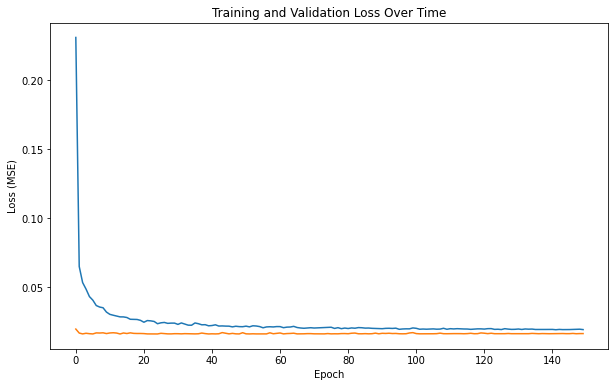

In [22]:
# Plot the graph of loss over time.
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Time')
# Make the graph bigger.
plt.gcf().set_size_inches(10, 6)

# Saving the Model

In [3]:
# Save the model.
# I have to use the .h5 format is used instead of the newer .keras format because the latter is not supported by the legacy Keras/TensorFlow 2.15.0 API.
model.save('my_model.h5')

# Using the Model to Make Predictions
As a proof of concept, we make predictions on only one chain of images.

In [32]:
import os
import cv2 as cv

UNSEEN_CHAIN_NAME = "0eca4aa82b"
ABSOLUTE_PATH_TO_CHAIN_FOLDER = os.path.abspath(f'../data/images/{UNSEEN_CHAIN_NAME}')
from predict_transformation_between_two_images import predict_transformation_between_two_images
from utils import *

net_returning_rotation = np.array([0, 0, 0, 1])
net_returning_translation = np.array([0, 0, 0])

NAME_OF_RESULTS_FILE = "results.csv"

# Write the header and the first row (reference image) of the output file.
with open(NAME_OF_RESULTS_FILE, 'w') as f:
    f.write("chain_id,i,x,y,z,qw,qx,qy,qz\n")
    f.write(f'{UNSEEN_CHAIN_NAME},0,0,0,0,0,0,0,1\n')

for i in range(1, 100):
    img_i = cv.imread(f'{ABSOLUTE_PATH_TO_CHAIN_FOLDER}/{i:03}.png')
    img_h = cv.imread(f'{ABSOLUTE_PATH_TO_CHAIN_FOLDER}/{i-1:03}.png')

    raw_inc_rotation, raw_inc_transformation = predict_transformation_between_two_images(img_i, img_h)

    # Normalise the values of the features.
    raw_inc_transformation /= 1000

    # Perform feature engineering.
    ESTIMATED_DISTANCE_TO_SPACECRAFT = (20 + 600) / 2 # metres
    ESTIMATED_DISTANCE_AFTER_NORMALISATION = (ESTIMATED_DISTANCE_TO_SPACECRAFT - 20) / (600 - 20)
    neural_network_input = np.hstack([np.array(ESTIMATED_DISTANCE_AFTER_NORMALISATION), raw_inc_rotation, raw_inc_transformation, raw_inc_rotation**2, raw_inc_transformation**2])
    neural_network_input = tf.convert_to_tensor(neural_network_input.reshape(1, -1), dtype=tf.float32)

    neural_network_output = model.predict(neural_network_input)

    # Undo the normalisations done to the outputs.
    incremental_translation = neural_network_output[0:3] * 1000
    incremental_rotation = neural_network_output[3:7]
    print(incremental_rotation)

    # Compute the net transformation.
    net_returning_rotation, net_returning_translation = compose_transformations(incremental_rotation, incremental_translation, net_returning_rotation, net_returning_translation)

    # Write the transformation to a file.
    with open(NAME_OF_RESULTS_FILE, 'a') as f:
        f.write(f'{UNSEEN_CHAIN_NAME},{i},{net_returning_translation[0]},{net_returning_translation[1]},{net_returning_translation[2]},\
                {net_returning_rotation[3]},{net_returning_rotation[0]},{net_returning_rotation[1]},{net_returning_rotation[2]}\n')





